In [3]:
import sys
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../')
from mpl_settings_v3 import *

from functions import edgelist_to_nn_set
from functions import ID_attack, RD_attack, ICI_attack, RCI_attack, percolate

networks = ['BA', 'ER']

attack_dict = {
    'Ran': r'$\mathrm{Rnd}$', 'Deg': r'$\mathrm{ID}$', 'DegU': r'$\mathrm{RD}$',
    'Btw': r'$\mathrm{IB}$', 'BtwU': r'$\mathrm{RB}$', 
    'Eigenvector': r'$\mathrm{IE}$', 'EigenvectorU': r'$\mathrm{RE}$',
    'CI': r'$\mathrm{ICI}$', 'CIU': r'$\mathrm{RCI}$', 'CIU2': r'$\mathrm{RCI2}$',
    'BtwU_cutoff3': r'$\mathrm{RB3}$'
}

def getLinearReg(sizes, values, return_r2=False):

    X = np.log(sizes)
    Y = np.log(values)
    coeffs, cov = np.polyfit(X, Y, 1, cov=True)
    errors = np.sqrt(np.diag(cov))
    
    intercept = coeffs[1]
    slope = coeffs[0]
    y_error = 3*errors[0] ## Use three times standard error
    Y_pred = intercept + X*slope
    
    if return_r2:
        return np.exp(Y_pred), slope, linear_regressor.score(X, Y)
    return np.exp(Y_pred), slope, y_error

In [5]:
N = 1000000
edgelists = {}

In [109]:
for network in networks:
    print(network)
    if network in edgelists:
        continue
    if network == 'BA':
        m = 5
        g = ig.Graph().Barabasi(N, m)
    elif network == 'ER':
        meank = 5
        p = meank / N
        g = ig.Graph().Erdos_Renyi(N, p)
    
    edgelist = []
    for e in g.es():
        edgelist.append(e.tuple)
    edgelists[network] = edgelist
    
orders = {}
N1_values_dict = {}

for network in networks:
    print(network)
    
    orders[network] = {}
    N1_values_dict[network] = {}

BA
ER
BA
ER


In [110]:
def attack_network(nn_set, attack):
    if attack == 'ID':
        order = ID_attack(nn_set)
    if attack == 'RD':
        order = RD_attack(nn_set)
    if attack == 'ICI':
        order = ICI_attack(nn_set, l=1)
    if attack == 'RCI':
        order = RCI_attack(nn_set, l=1)
    if attack == 'ICI2':
        order = ICI_attack(nn_set, l=2)
    if attack == 'RCI2':
        order = RCI_attack(nn_set, l=2)
    if attack == 'Ran':
        order = np.arange(len(nn_set))
        np.random.shuffle(order)
    return order

#attacks = ['ID', 'RD', 'ICI', 'ICI2', 'RCI', 'RCI2']
#attacks = ['ID', 'ICI', 'ICI2']
attacks = ['ID', 'RD', 'Ran']
iterations = 10
for network in networks:
    print(network)
    if attack in orders[network]:
        continue
        
    edgelist = edgelists[network]
    
    for attack in attacks:
        nn_set = edgelist_to_nn_set(edgelist)
        order = attack_network(nn_set, attack)[::-1]
        orders[network][attack] = order

    for attack in attacks:
        print('---', attack)
        order = orders[network][attack]
        nn_set = edgelist_to_nn_set(edgelist)
        if attack == 'Ran' and network == 'BA':
            _N1_values = []
            for i in range(iterations):
                np.random.shuffle(order)
                _N1_values.append(percolate(nn_set, order))
            N1_values = np.mean(_N1_values, axis=0)
            
        else:
            N1_values = percolate(nn_set, order)
        N1_values_dict[network][attack] = N1_values

BA
--- ID
--- RD
--- Ran
ER
--- ID
--- RD
--- Ran


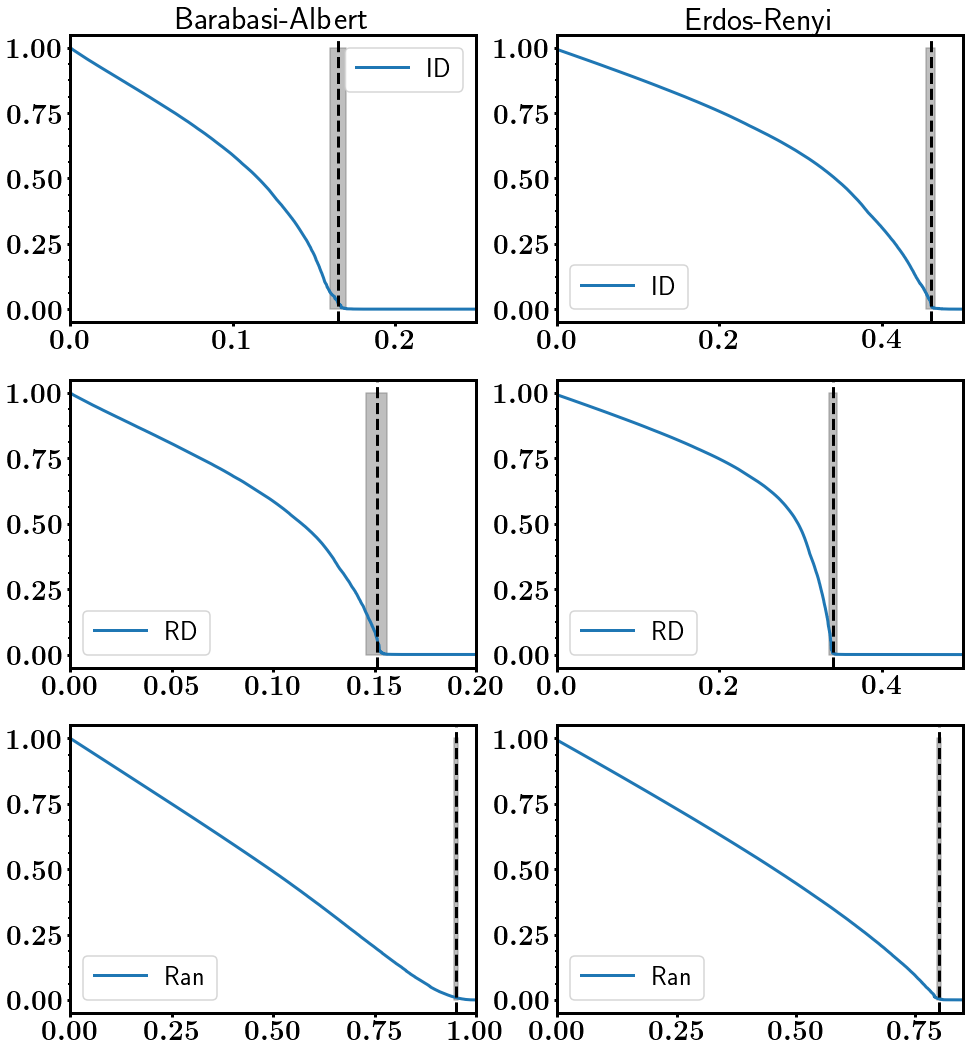

In [135]:
X = (np.arange(N)/N)[::-1]
delta_fc = 0.005

ncols=2
nrows=3
fig, all_axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

fontsize=32
all_axes[0,1].set_title('Erdos-Renyi', fontsize=fontsize)
all_axes[0,0].set_title('Barabasi-Albert', fontsize=fontsize)

for i, attack in enumerate(attacks):
    axes = all_axes[i]

    network = 'BA'
    ax = axes[0]
    Y = np.array(N1_values_dict[network][attack])/N
    ax.plot(X, Y, '-', label=attack)
    if attack == 'RD':
        ax.set_xlim(0, 0.2)
        fc = 0.151
        ax.axvline(fc, color='k', linestyle='--')
        ax.fill_betweenx([0,1], fc-delta_fc, fc+delta_fc, alpha=0.5, color='grey')
    elif attack == 'Ran':
        ax.set_xlim(0, 1)
        fc = 0.95
        ax.axvline(fc, color='k', linestyle='--')
        ax.fill_betweenx([0,1], fc-delta_fc, fc+delta_fc, alpha=0.5, color='grey')
    elif attack == 'ID':
        ax.set_xlim(0, 0.25)
        fc = 0.165
        ax.axvline(fc, color='k', linestyle='--')
        ax.fill_betweenx([0,1], fc-delta_fc, fc+delta_fc, alpha=0.5, color='grey')
    ax.legend()
    
    network = 'ER'
    ax = axes[1]
    ax.plot(X, np.array(N1_values_dict[network][attack])/N, '-', label=attack)
    if attack == 'RD':
        ax.set_xlim(0, 0.5)
        fc = 0.34
        ax.axvline(fc, color='k', linestyle='--')
        ax.fill_betweenx([0,1], fc-delta_fc, fc+delta_fc, alpha=0.5, color='grey')
    elif attack == 'Ran':
        ax.set_xlim(0, 0.85)
        fc = 0.8
        ax.axvline(fc, color='k', linestyle='--')
        ax.fill_betweenx([0,1], fc-delta_fc, fc+delta_fc, alpha=0.5, color='grey')
    elif attack == 'ID':
        ax.set_xlim(0, 0.5)
        fc = 0.46
        ax.axvline(fc, color='k', linestyle='--')
        ax.fill_betweenx([0,1], fc-delta_fc, fc+delta_fc, alpha=0.5, color='grey')
    ax.legend()
plt.show()

In [15]:
all_comp_sizes_dict = {}
_attacks = ['DegU', 'Deg', 'Ran']
for network in networks:
    all_comp_sizes_dict[network] = {}
    for attack in _attacks:
        all_comp_sizes_dict[network][attack] = {}

In [68]:
all_f_values = {
    'BA': {'DegU': ['0.150', '0.151', '0.152'], 'Deg': ['0.165', '0.166', '0.167'], 'Ran': ['0.94', '0.95', '0.96', '0.97', '0.98', '0.99']},
    'ER': {'DegU': ['0.339', '0.34', '0.341'], 'Deg': ['0.459', '0.461', '0.46'], 'Ran': ['0.8']}
}

all_f_values = {
    'BA': {'DegU': ['0.151'], 'Deg': ['0.165'], 'Ran': ['0.97']},
    'ER': {'DegU': ['0.3401'], 'Deg': ['0.4652'], 'Ran': ['0.8']}

}

m = 5
meank = 5
for network in networks:
    print(network)
    for attack in _attacks:
        print(attack)
        f_values = all_f_values[network][attack]

        if network == 'BA':
            net_dir_name = '../../networks/BA/BA_m{:02}'.format(m)
            base_net_name = 'BA_m{:02}_N{}'.format(m, N)
            base_net_dir_name = os.path.join(net_dir_name, base_net_name)
        elif network == 'ER':
            net_dir_name = '../../networks/ER/ER_k{:.2f}'.format(meank)
            base_net_name = 'ER_k{:.2f}_N{}'.format(meank, N)
            base_net_dir_name = os.path.join(net_dir_name, base_net_name)

        for f_value in f_values:
            print(f_value)
            if f_value in all_comp_sizes_dict[network][attack]:
                print('already loaded')
                continue
            comp_sizes_file = 'comp_sizes_{}_f{}.txt'.format(attack, f_value)
            full_comp_sizes_file = os.path.join(base_net_dir_name, comp_sizes_file)
            comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)

            all_comp_sizes_dict[network][attack][f_value] = comp_sizes

BA
DegU
0.151
already loaded
Deg
0.165
already loaded
Ran
0.97
already loaded
ER
DegU
0.3401
already loaded
Deg
0.4652
already loaded
Ran
0.8
already loaded


-2.5334029675672114 0.021284054861384172
-2.5103383118367577 0.017952242287606616
-2.616461632530952 0.10183986722878942
-2.473131201933388 0.013373467660962776
-2.4707841573374707 0.01660038759115817
-2.497597938931687 0.031049419913452114


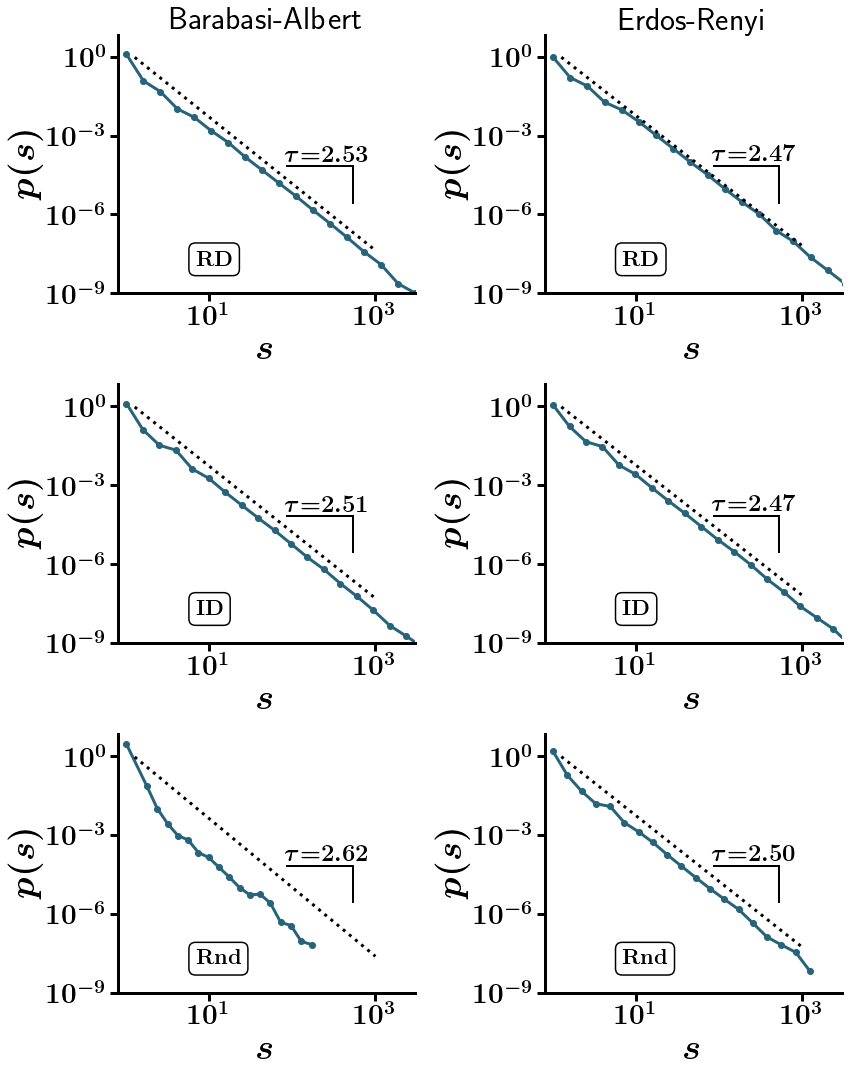

In [71]:
def powerlaw(X, a, c):
    return c*X**(-a)

def _getLinearReg(sizes, values, return_r2=False):
    linear_regressor = LinearRegression() 
    X = np.log(sizes).reshape(-1, 1)
    Y = np.log(values).reshape(-1, 1)
    linear_regressor.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor.predict(X)  # make predictions
    slope = linear_regressor.coef_[0][0]
    if return_r2:
        return np.exp(Y_pred), slope, linear_regressor.score(X, Y)
    return np.exp(Y_pred), slope

def plot_comp_distribution(all_f_values):
    
    def get_histo(comp_sizes):
        mask = comp_sizes > 0
        comp_sizes = comp_sizes[mask]     
        min_s = np.min(comp_sizes)
        max_s = np.max(comp_sizes)
        bins = np.logspace(np.log10(min_s), np.log10(max_s), 20)
        hist = np.histogram(comp_sizes, bins=bins, density=True)
        hist_norm = hist[0]
        hist_norm[hist_norm==0] = np.NaN
        mask = ~np.isnan(hist_norm)
        X = bins[:-1]
        X = X[mask]
        Y = hist_norm[mask]

        return X, Y

    def plot_five_values(attack, comp_sizes, f_values, ax):
        for i, f_value in enumerate(f_values):
            X, Y = get_histo(comp_sizes[f_value])
            
            if False:
            
                #if i == 0:
                #    ax.plot(X, Y, '-.', marker='s', color=_colors[0], alpha=0.5)
                if i == 0:
                    ax.plot(X, Y, '-.', marker='s', color=_colors[0], label=r'$f<f_c$')
                if i == 1:
                    ax.plot(X, Y, '-' , marker='o', color=_colors[1], label=r'$f=f_c$')
                if i == 2:
                    ax.plot(X, Y, '--', marker='^', color=_colors[2], label=r'$f>f_c$')
                #if i == 4:
                #    ax.plot(X, Y, '--', marker='^', color=_colors[2], alpha=0.5)
            else:
                ax.plot(X, Y, '-' , marker='o', color=_colors[1], label=r'$f=f_c$')
                
            bbox = {'boxstyle': 'round', 'fc': 'None'}
            #ax.text(0.9, 0.85, attack_dict[attack], fontsize=20, 
            ax.text(0.26, 0.11, attack_dict[attack], fontsize=22, 
                    transform=ax.transAxes, bbox=bbox, horizontalalignment='left')
        
            if i == 2 or len(f_values) < 2:
                Y_pred, slope, y_err = getLinearReg(X[4:-1], Y[4:-1], return_r2=False)
        
        return Y_pred, slope, y_err/3
            
    _colors = ['#ca3542', '#27647b', '#57575f']
    ylim = (1E-9, 7)
    xlim = (0.8, 3000)
    ncols = 2
    nrows = 3
    fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

    fontsize=32
    axes[0,1].set_title('Erdos-Renyi', fontsize=fontsize)
    axes[0,0].set_title('Barabasi-Albert', fontsize=fontsize)
    
    for ax in axes.flatten():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.tick_params(which='minor', length=5)
        ax.tick_params(which='major', length=8)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        ax.set_xlabel(r'$s$', fontsize=36)
        ax.set_ylabel(r'$p(s)$', fontsize=36)    


    
    for j, network in enumerate(networks):
        for i, attack in enumerate(_attacks):
            ax = axes[i,j]
            f_values = all_f_values[network][attack]
            Y_pred, slope, r2 = plot_five_values(attack, all_comp_sizes_dict[network][attack], f_values, ax)
            print(slope, r2)
            tau = -slope
            X = np.logspace(0.1, 3, 100)
            Y = powerlaw(X, tau, 1.7)
            ax.plot(X, Y, ':', color='k', label=r'$\tau$')

            ax.text(0.56, 0.51, r'$\tau$' + r'$=$' + r'${{{:.2f}}}$'.format(tau), 
                    transform=ax.transAxes, fontsize=24)
            line = ax.axhline(0.49, 0.57, 0.79, color='k', linewidth=2)
            line.set_transform(ax.transAxes)
            line = ax.axvline(0.79, 0.49, 0.35, color='k', linewidth=2)
            line.set_transform(ax.transAxes)
    
    plt.tight_layout()
    #fig_name = os.path.join(fig_dir, 'comp_sizes')
    #plt.savefig(fig_name + '.png')
    #plt.savefig(fig_name + '.pdf')

    plt.show()
    
plot_comp_distribution(all_f_values)